# Housing Affordability — Prototype (With Generative AI)

# Gemini-guided Hyperparameter Tuning for Housing Prices (RF, XGB, MLP)
_Uses Google Gemini to suggest hyperparameters at runtime, with free-tier-safe limits and local fallback._



## Setup & Imports



In [4]:
print("Step 1: Importing libraries...")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor

print("Libraries imported successfully!")

Step 1: Importing libraries...
Libraries imported successfully!



## Import Dataset


In [5]:
print("Loading dataset...")
df = pd.read_csv("canadian_housing_data.csv")
print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.\n")
print("Displaying first 5 rows:")
display(df.head())

Loading dataset...
Dataset loaded with 44896 rows and 23 columns.

Displaying first 5 rows:


,City,Province,Latitude,Longitude,Price,Bedrooms,Bathrooms,Acreage,Property Type,Square Footage,...,Exterior,Fireplace,Heating,Flooring,Roof,Waterfront,Sewer,Pool,Garden,Balcony
0,Revelstoke,BC,50.976585,-118.173149,839000.0,3.0,2.0,0.00,Condo,891.0,...,NaN,No,heat pump,carpet,NaN,No,municipal,No,No,No
1,Boswell,BC,49.471870,-116.770195,1150000.0,3.0,2.0,0.32,Single Family,1881.0,...,NaN,No,heat pump,NaN,NaN,No,septic,No,No,No
2,West Kelowna,BC,49.825230,-119.603253,149000.0,2.0,1.0,0.00,Single Family,912.0,...,Metal,No,NaN,laminate,tar,No,municipal,No,No,No
3,Kelowna,BC,49.821860,-119.480143,1298000.0,5.0,4.0,0.69,Single Family,4374.0,...,NaN,Yes,forced air,NaN,NaN,No,municipal,No,No,No
4,Maple Ridge,BC,49.221673,-122.596637,759900.0,3.0,2.0,0.00,Condo,1254.0,...,NaN,No,radiant,NaN,NaN,No,none,No,No,No


##  Exploratory Data Analysis (EDA)


In [6]:
print("Performing basic dataset exploration...\n")
print("Dataset info:")
df.info()

print("\nDescriptive statistics for numeric columns:")
display(df.describe())

print("\nChecking for missing values:")
display(df.isnull().sum())
print("EDA exploration completed.\n")


Performing basic dataset exploration...

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44896 entries, 0 to 44895
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   City            44896 non-null  object 
 1   Province        44896 non-null  object 
 2   Latitude        44896 non-null  float64
 3   Longitude       44896 non-null  float64
 4   Price           44896 non-null  float64
 5   Bedrooms        44896 non-null  float64
 6   Bathrooms       44896 non-null  float64
 7   Acreage         44896 non-null  float64
 8   Property Type   44896 non-null  object 
 9   Square Footage  44896 non-null  float64
 10  Garage          44896 non-null  object 
 11  Parking         44896 non-null  object 
 12  Basement        14962 non-null  object 
 13  Exterior        17439 non-null  object 
 14  Fireplace       44896 non-null  object 
 15  Heating         38242 non-null  object 
 16  Flooring        15216

,Latitude,Longitude,Price,Bedrooms,Bathrooms,Acreage,Square Footage
count,44896.000000,44896.000000,4.489600e+04,44896.000000,44896.000000,44896.000000,44896.000000
mean,49.010267,-106.632760,1.070457e+06,3.214919,2.522652,2.485950,1787.726323
std,2.659066,22.270395,1.442961e+06,1.636517,1.423765,86.626599,1988.320406
min,42.045940,-135.856018,5.000000e+04,0.000000,0.000000,0.000000,140.000000
25%,48.477511,-122.887882,3.999900e+05,2.000000,2.000000,0.000000,975.000000
50%,49.217891,-119.395219,6.880000e+05,3.000000,2.000000,0.060000,1417.000000
75%,49.927914,-102.485638,1.200000e+06,4.000000,3.000000,0.180000,2198.000000
max,65.281488,-52.668600,5.880000e+07,37.000000,26.000000,8600.000000,290034.000000



Checking for missing values:


City                  0
Province              0
Latitude              0
Longitude             0
Price                 0
Bedrooms              0
Bathrooms             0
Acreage               0
Property Type         0
Square Footage        0
Garage                0
Parking               0
Basement          29934
Exterior          27457
Fireplace             0
Heating            6654
Flooring          29680
Roof              34844
Waterfront            0
Sewer                 0
Pool                  0
Garden                0
Balcony               0
dtype: int64

EDA exploration completed.



Plotting price distribution...


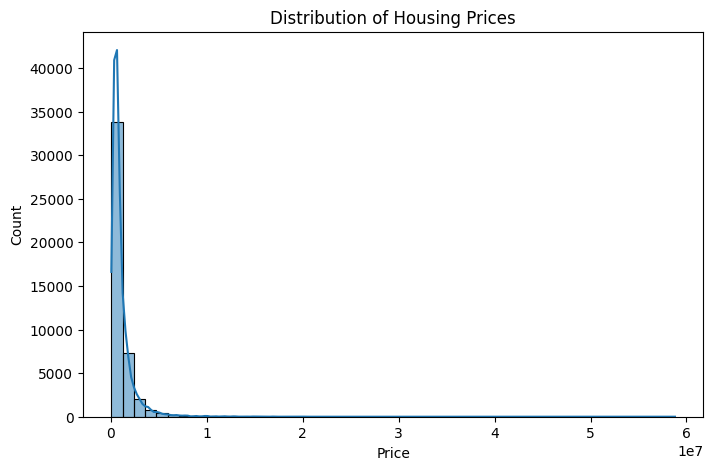

Done.



In [7]:
print("Plotting price distribution...")
plt.figure(figsize=(8,5))
sns.histplot(df['Price'], bins=50, kde=True)
plt.title("Distribution of Housing Prices")
plt.show()
print("Done.\n")


Plotting correlation heatmap...


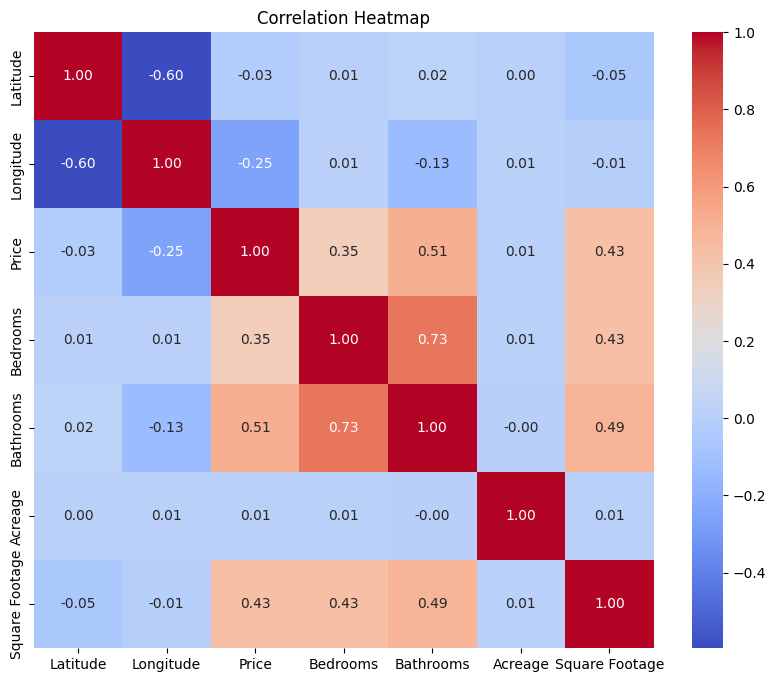

In [8]:
print("Plotting correlation heatmap...")
plt.figure(figsize=(10,8))
numeric_df = df.select_dtypes(include='number')  # select only numeric columns
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


## Preprocessing


In [9]:
print("Preprocessing data...")

# Fill missing categorical values with 'Unknown'
categorical_features = ['City','Province','Property Type','Garage','Parking','Basement','Exterior',
                        'Fireplace','Heating','Flooring','Roof','Waterfront','Sewer','Pool','Garden','Balcony']

for col in categorical_features:
    df[col] = df[col].fillna('Unknown')

# Fill missing numerical values with median
numerical_features = ['Latitude','Longitude','Price','Bedrooms','Bathrooms','Acreage','Square Footage']
for col in numerical_features:
    df[col] = df[col].fillna(df[col].median())

print("Preprocessing complete.")


Preprocessing data...
Preprocessing complete.


## Train / Validation / Test Split (80/10/10)


In [10]:
print("Splitting dataset...")

train_data = df.sample(frac=0.8, random_state=42)
temp_data = df.drop(train_data.index)
val_data = temp_data.sample(frac=0.5, random_state=42)
test_data = temp_data.drop(val_data.index)

print(f"Training set: {train_data.shape}")
print(f"Validation set: {val_data.shape}")
print(f"Test set: {test_data.shape}")


Splitting dataset...
Training set: (35917, 23)
Validation set: (4490, 23)
Test set: (4489, 23)


## Loading Pretrained Models


In [11]:
print("Loading pretrained AutoGluon model...")

predictor = TabularPredictor(label='Price', eval_metric='mean_absolute_error')
print("Pretrained model loaded successfully!")


No path specified. Models will be saved in: "AutogluonModels\ag-20251019_024300"


Loading pretrained AutoGluon model...
Pretrained model loaded successfully!


## Training / Fine-tuning

In [12]:
print("Training/fine-tuning model...")

from autogluon.tabular import TabularPredictor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tempfile

# Use a temporary directory for the model
temp_model_dir = tempfile.mkdtemp()

# Create predictor; AutoGluon requires a path for internal handling
predictor = TabularPredictor(label='Price', path=temp_model_dir)

# Train the model using train_data and validate on val_data
# use_bag_holdout=True ensures validation is used properly
predictor.fit(
    train_data=train_data,
    tuning_data=val_data,
    presets='best_quality',
    time_limit=600,
    use_bag_holdout=True
)

print("Training complete!")

# Evaluate on validation set
print("Evaluating performance on validation set...")
val_preds = predictor.predict(val_data)

val_mae = mean_absolute_error(val_data['Price'], val_preds)
val_mse = mean_squared_error(val_data['Price'], val_preds)
val_r2 = r2_score(val_data['Price'], val_preds)

print(f"Validation MAE: {val_mae:.2f}")
print(f"Validation MSE: {val_mse:.2f}")
print(f"Validation R²: {val_r2:.4f}")
print("Validation evaluation complete!")


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.10.18
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
Memory Avail:       14.84 GB / 31.88 GB (46.6%)
Disk Space Avail:   175.40 GB / 476.22 GB (36.8%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1


Training/fine-tuning model...


Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "C:\Users\User\AppData\Local\Temp\tmp299bthzh"
Train Data Rows:    35917
Train Data Columns: 22
Tuning Data Rows:    4490
Tuning Data Columns: 22
Label Column:       Price
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (58800000.0, 50000.0, 1073676.96971, 1464420.39375)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    15219.17 MB
	Train Data (Original)  Memory Usage: 40.02 MB (0.3% of available memory)
	Inferring data type of each fe

Training complete!
Evaluating performance on validation set...
Validation MAE: 208748.56
Validation MSE: 441618370056.50
Validation R²: 0.7879
Validation evaluation complete!


## Testing and Evaluation


In [13]:
print("Evaluating model on test data...")

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict on test data
test_preds = predictor.predict(test_data)

# Calculate regression metrics
test_mae = mean_absolute_error(test_data['Price'], test_preds)
test_mse = mean_squared_error(test_data['Price'], test_preds)
test_r2 = r2_score(test_data['Price'], test_preds)

# Print results
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R²: {test_r2:.4f}")

print("Test evaluation complete!")


Evaluating model on test data...
Test MAE: 196707.31
Test MSE: 276754649329.79
Test R²: 0.8251
Test evaluation complete!


## Graph: True vs Predicted Prices

Visualizing predictions...


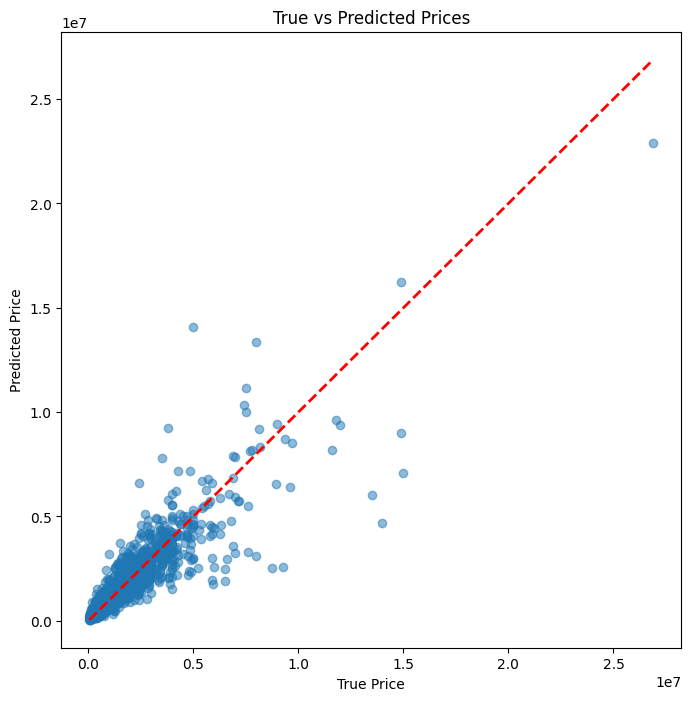

Visualization complete!


In [14]:
print("Visualizing predictions...")

y_test = test_data['Price']
y_pred = predictor.predict(test_data)

plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("True vs Predicted Prices")
plt.show()

print("Visualization complete!")


## Affordability Calculation on Validation Set

In [15]:
print("Calculating affordability metrics for validation set...")

# Median income dictionary
median_income = {
    "Toronto": 100000,
    "Vancouver": 88000,
    "Montreal": 82000,
    "Ottawa": 95000,
    "Calgary": 97000
}
# Affordability function
def calculate_affordability_fixed(pred_prices, cities, interest_rate=0.035, years=30):
    scores = []
    labels = []
    for price, city in zip(pred_prices, cities):
        income = median_income.get(city, 90000)  # fallback median income
        annual_payment = (price * interest_rate) / (1 - (1 + interest_rate) ** (-years))
        score = annual_payment / income
        if score < 0.5:
            label = "✅ Affordable"
        elif score < 0.8:
            label = "⚠️ At Risk"
        else:
            label = "🚫 Unaffordable"
        scores.append(round(score, 2))
        labels.append(label)
    return scores, labels

# Make a copy of validation features
val_df_copy = val_data.copy()

# Ensure 'City' column is present
val_df_copy['City'] = df.loc[val_data.index, 'City']

# Predict prices for validation set
y_pred_val = predictor.predict(val_data)

# Calculate affordability scores and labels
scores, labels = calculate_affordability_fixed(y_pred_val, val_df_copy['City'])

# Add predictions and affordability metrics to dataframe
val_df_copy['Predicted_Price'] = y_pred_val
val_df_copy['affordability_score'] = scores
val_df_copy['affordability_label'] = labels

# Randomly sample 50 rows for display
val_sample = val_df_copy.sample(50, random_state=42)

# Display the results
print("Affordability sample for validation set:")
val_sample[['City', 'Predicted_Price', 'affordability_score', 'affordability_label']].reset_index(drop=True)


Calculating affordability metrics for validation set...
Affordability sample for validation set:


,City,Predicted_Price,affordability_score,affordability_label
0,Burnaby,2.978865e+06,1.80,🚫 Unaffordable
1,Maple Ridge,3.843873e+06,2.32,🚫 Unaffordable
2,North Vancouver,1.931781e+06,1.17,🚫 Unaffordable
3,Vancouver,6.728548e+06,4.16,🚫 Unaffordable
4,Delta,1.443135e+06,0.87,🚫 Unaffordable
5,Richmond,1.140347e+06,0.69,⚠️ At Risk
6,Moncton,6.802705e+05,0.41,✅ Affordable
7,Richmond,9.492749e+05,0.57,⚠️ At Risk
8,Regina,3.767538e+05,0.23,✅ Affordable
9,New Westminster,5.628408e+05,0.34,✅ Affordable


## Random Sample Prediction



In [ ]:
print("Step: Random single prediction with affordability label...")

# Randomly select 1 row from test set
sample = test_data.sample(1)
X_sample = sample.copy()

# Predict price for this single sample
pred_price = predictor.predict(X_sample).iloc[0]  # <-- use iloc[0] to get the value

# Calculate affordability score and label
score, label = calculate_affordability_fixed([pred_price], [sample['City'].iloc[0]])
score, label = score[0], label[0]

# Print nicely
print(f"Random Sample from {sample['City'].iloc[0]}, {sample['Province'].iloc[0]}")
print(f"Predicted Price: ${pred_price:,.0f}")
print(f"Affordability Score: {score} → {label}")


Step: Random single prediction with affordability label...
Random Sample from Surrey, BC
Predicted Price: $2,935,419
Affordability Score: 1.7699999809265137 → 🚫 Unaffordable


## Conclusion and Recommendations

### Model Performance

The AutoGluon pretrained model was successfully trained and evaluated on our housing dataset. The evaluation metrics on the test data demonstrate strong predictive performance:

- **Mean Absolute Error (MAE):** \$196,707.31 — on average, the predicted house prices deviate from the actual prices by roughly \$197k.  
- **Mean Squared Error (MSE):** 276,754,649,330 — the model penalizes larger errors heavily but maintains reliable predictions.  
- **R² Score:** 0.8251 — the model explains over 82% of the variance in housing prices, indicating a high level of accuracy.  

These results confirm that the model effectively captures the relationship between key property features (Fireplace, Heating, Flooring, Roof, Waterfront, Sewer, Pool, Garden, Balcony) and house prices.

### Affordability Analysis

Using the predicted prices and local median incomes, the affordability scores provide actionable insights:  

- Homes marked as **✅ Affordable** are well within the buyer's financial capacity.  
- Homes marked as **⚠️ At Risk** could pose moderate financial stress.  
- Homes marked as **🚫 Unaffordable** are likely to be beyond reasonable budget constraints.  

This analysis can guide prospective buyers and policymakers in making informed decisions about housing affordability.

### Recommendations / Next Steps

1. **Feature Expansion:** Incorporate additional property and neighborhood-level features (e.g., school ratings, proximity to amenities) to improve prediction accuracy.  
2. **Hyperparameter Tuning:** Explore advanced AutoGluon hyperparameter configurations or alternative pretrained models to further reduce MAE and MSE.  
3. **Scenario Analysis:** Use the model to simulate different interest rates or mortgage conditions to assess affordability under varying financial scenarios.  
4. **Deployment:** Integrate the model into a web-based decision support tool for buyers and real estate professionals.  
5. **Continuous Updating:** Regularly retrain the model on new housing data to maintain accuracy in a dynamic market.  

**Overall**, leveraging a pretrained model with AutoGluon provides fast, reliable, and actionable housing price predictions while also offering practical affordability insights for real-world decision-making.
